# Hypothesis Testing With Insurance Data
- Michael Vincent
- 9/27

## Imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## Load the data

In [2]:
# Load the data
df = pd.read_csv('data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Question 1

Null and alternative hypotheses:

$H_0$: There is no difference in the insurance charges for smokers and nonsmokers. 

$H_1$: The insurance charges for smokers are higher than nonsmokers.

> We have two groups being compared over a continuous variable so we will use a two sample $t$-test for this hypothesis test.

In [3]:
# Split the data into smokers and nonsmokers
smokers = df[df['smoker'] == 'yes'].copy()
nonsmokers = df[df['smoker'] == 'no'].copy()

# Get the insurance charges for each group
smokers_charges = smokers['charges']
nonsmokers_charges = nonsmokers['charges']

In [4]:
# Check for outliers among the smokers
smokers_zscores = stats.zscore(smokers_charges)
smokers_outliers = abs(smokers_zscores) > 3
sum(smokers_outliers)

0

> There are no outliers for the insurance charges of smokers.

In [5]:
# Check for outliers among the nonsmokers
nonsmokers_zscores = stats.zscore(nonsmokers_charges)
nonsmokers_outliers = abs(smokers_zscores) > 3
sum(nonsmokers_outliers)

0

> There are no outliers for the insurance charges of nonsmokers

In [6]:
# Check each group for normality
print(stats.normaltest(smokers_charges))
print(stats.normaltest(nonsmokers_charges))

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)
NormaltestResult(statistic=316.4528082392722, pvalue=1.9193129759002216e-69)


> Both tests have $p$-values less than 0.05, so we reject the null hypothesis that the each group is normal.

In [7]:
# Check the sample sizes
print(len(smokers_charges))
print(len(nonsmokers_charges))

274
1064


> Each group has a sample size larger than 30, so we can proceed with a 2 sample $t$-test. (Provided we meet the equal variance assumption.)

In [8]:
# Check for equal variance
stats.levene(smokers_charges, nonsmokers_charges)

LeveneResult(statistic=332.6135162726081, pvalue=1.5593284881803726e-66)

> Our $p$-value is less than 0.05, so we reject the null hypothesis that the samples have equal variance. We can proceed with the 2 sample $t$-test provided we pass the parameter equal_var = False.

In [9]:
# Perform the 2 sample t-test
results = stats.ttest_ind(smokers_charges, nonsmokers_charges, 
                          equal_var = False)
results

Ttest_indResult(statistic=32.751887766341824, pvalue=5.88946444671698e-103)

> Our $p$-value is less than our $\alpha$ of 0.05 so we reject the null hypothesis. That is, our data supports the claim that the insurance charges for smokers are higher than the insurance charges for nonsmokers.

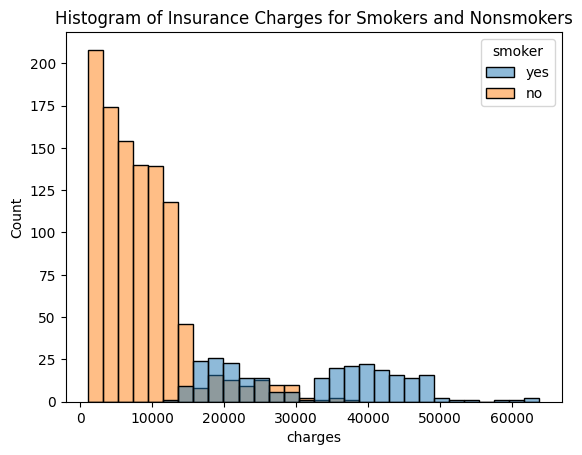

In [38]:
# Make histograms for the insurance charges for smokers and nonsmokers.
sns.histplot(x = df['charges'], hue = df['smoker']);
plt.title('Histogram of Insurance Charges for Smokers and Nonsmokers');

> We see from these histograms that smokers do indeed accrue more of the higher insurance charges. This is not surprising. What is curious about this graph is that nonsmokers accrue more lower insurance charges. Perhaps this is because nonsmokers are more likely to be proactive with their health and are therefore more likely to make routine doctor visits.

## Question 2

Null and alternative hypotheses:

$H_0:$ Men are just as likely to be smokers as women.

$H_1:$ There are more male smokers than female smokers.

> We have two groups being compared across two categories so we will use a Chi-square test.

In [11]:
# Construct the contingency table for the hypothesis test.
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [12]:
# Check the ratios of smokers among the genders.
print(f'{round(159 / 517 * 100)}% of the men in our sample are smokers.')
print(f'{round(115 / 547 * 100)}% of the women in our sample are smokers.')

31% of the men in our sample are smokers.
21% of the women in our sample are smokers.


> Our sample data does suggest men smoke at a greater rate than women. Our hypothesis test will tell us if this result is significant.

In [13]:
# Perform the hypothesis test
chi2, p, deg_free, expected_vals = stats.chi2_contingency(table)
p

0.006548143503580696

> Our $p$-value is less than our $\alpha$ of 0.05, so our data supports the claim that men are more likely to smoke than women.

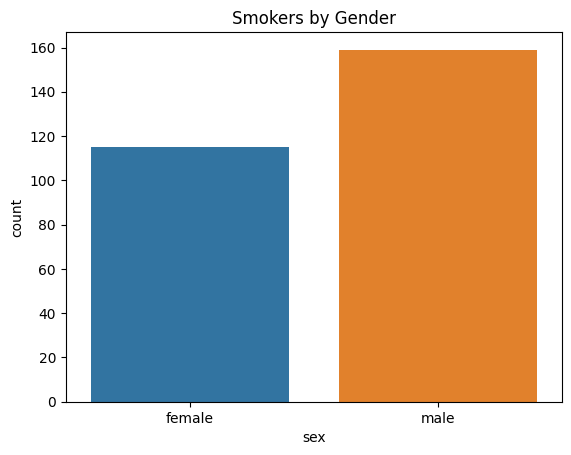

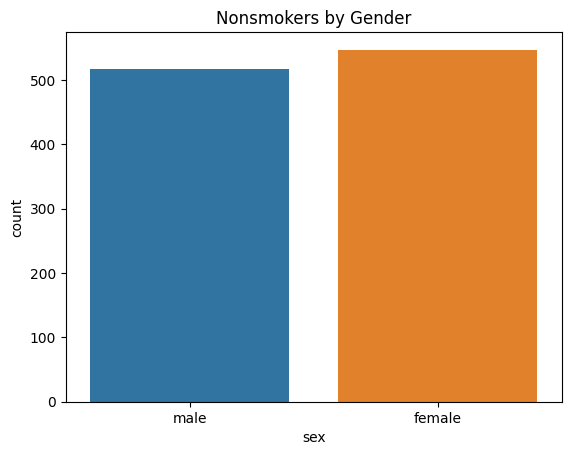

In [14]:
smokers = df[df['smoker'] == 'yes']
nonsmokers = df[df['smoker'] == 'no']
sns.countplot(x = smokers['sex']);
plt.title('Smokers by Gender');
plt.show()
sns.countplot(x = nonsmokers['sex']);
plt.title('Nonsmokers by Gender');

## Question 3

Null and alternative hypotheses:

$H_0$: The average insurance charge is the same regardless of region.

$H_1$: There are significant differences in the insurance charges across the different regions.

In [15]:
# Find out how many regions there are
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

> There are four regions, and since insurance charges are a continuous variable we will use an ANOVA test.

In [16]:
# Make a dictionary for the different regions
groups = {}
for region in df['region'].unique():
    groups[region] = df.loc[df['region'] == region, 'charges'].copy()
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [17]:
# Check the normality and sample size for each group
norm_results = {}
for region, data in groups.items():
    stat, p = stats.normaltest(data)
    norm_results[region] = {'n': len(data),
                            'p': p,
                            'test stat': stat,
                            'is normal': p > 0.05}
pd.DataFrame(norm_results).T

,n,p,test stat,is normal
southwest,325,0.0,102.294059,False
southeast,364,0.0,65.877446,False
northwest,325,0.0,107.23285,False
northeast,324,0.0,86.747629,False


> None of the groups are normal, however the sample size for each group is large enough that we may proceed with an ANOVA hypothesis test.

In [18]:
# Test for equal variance
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

> Our $p$-value is less than 0.05, so we reject the null hypothesis that the groups have the same variance. We will use the Kruskal-Wallis test since we don't have equal variance.

In [21]:
# Perform the hypothesis test.
results = stats.kruskal(*groups.values())
results

KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

> Our $p$-value is greater than our $\alpha$ of 0.05 so we fail to reject the null hypothesis. That is, the evidence is not strong enough to claim there is a significant difference in the insurance charges across the different regions.

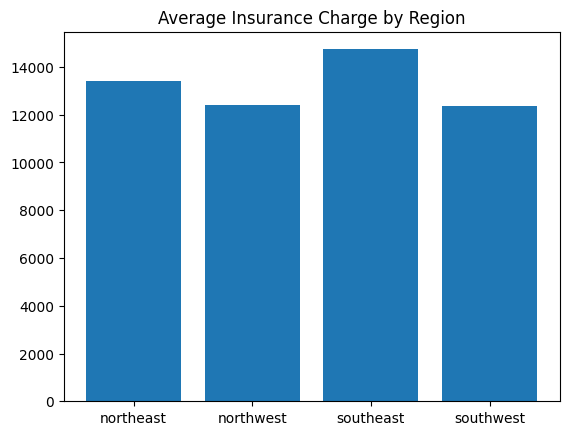

In [37]:
# Construct a barplot of the average insurance charge by region.
plt.bar(x = df.groupby('region')['charges'].mean().index,
        height = df.groupby('region')['charges'].mean().values);
plt.title('Average Insurance Charge by Region');